# SAD - Project 2

In [17]:
library(glue)
library(readr)
library(tidyr)
library(raster)
library(ggplot2)
library(tidyverse)
library(zoo)
library(dplyr)
options(readr.show_col_types = FALSE)

## Problem no.1

In [2]:
# wyciąganie walut
read.csv("data/EU_deposits_1yr_data.csv", skip=2, nrows = 1, header = F) -> headers2
read.csv("data/EU_deposits_1yr_data.csv", skip=50, nrows = 1, header = F) -> df2
headers2[1] <- "Date"
as.matrix(headers2) -> m_headers2
colnames(df2) <- m_headers2
country_currency_tibble <- as_tibble(df2) %>% select_if(~ !any(is.na(.))) %>% pivot_longer(cols=-1) %>% select(name) %>% separate(name, into=c('Country','Currency'),sep=', ') %>% mutate(names=str_replace(Currency,"^(?!.*Euro).*$", "non-Euro")) %>% select(-Currency) %>% rename(Currency=names)

In [3]:
# dane o inflacji
read_csv("data/EU_Inflation_HICP_data.csv", skip=37, n_max = 150) -> dt
read.csv("data/EU_Inflation_HICP_data.csv", skip=2, nrows = 1, header = F) -> headers
headers[1] <- "Dates"
as.matrix(headers) -> m_headers
colnames(dt) <- m_headers
transform(dt, Dates = as.Date(paste0(dt$Dates, '01'), '%Y%b%d')) -> df
as_tibble(df) -> dt

New names:
• `1.0` -> `1.0...3`
• `3.1` -> `3.1...4`
• `1.0` -> `1.0...5`
• `1.6` -> `1.6...7`
• `2.0` -> `2.0...10`
• `0.9` -> `0.9...11`
• `1.1` -> `1.1...12`
• `1.6` -> `1.6...13`
• `0.9` -> `0.9...17`
• `1.1` -> `1.1...22`
• `1.3` -> `1.3...23`
• `1.3` -> `1.3...27`
• `2.0` -> `2.0...28`
• `3.1` -> `3.1...29`


Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


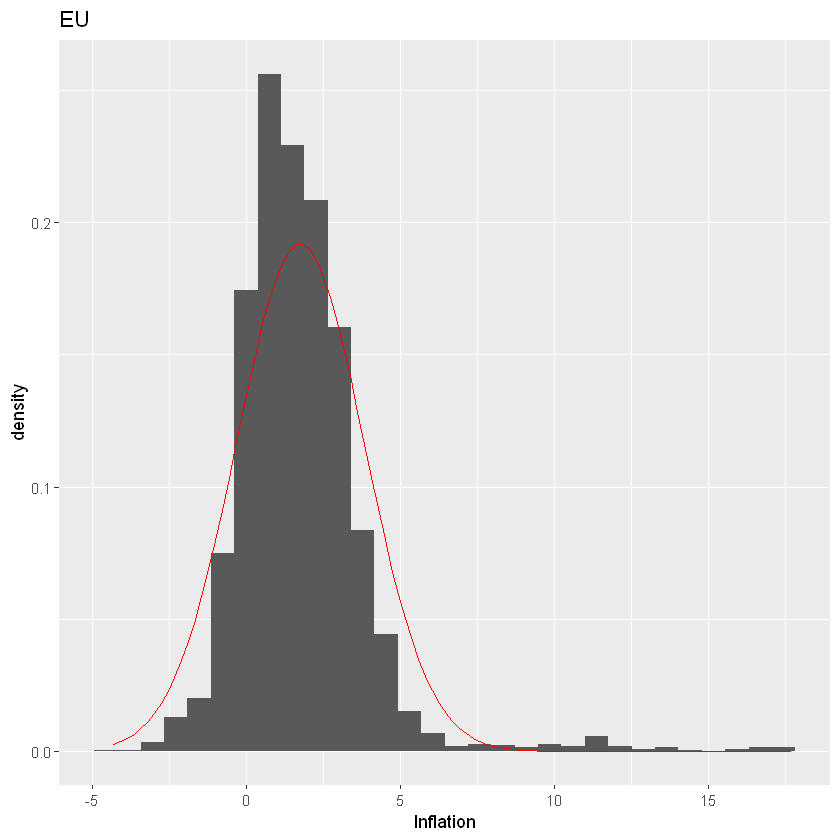


	Shapiro-Wilk normality test

data:  dt_eu$value
W = 0.83997, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  dt_noneu$value
W = 0.91724, p-value < 2.2e-16



	Wilcoxon rank sum test with continuity correction

data:  dt_eu$value and dt_noneu$value
W = 1329864, p-value = 4.764e-08
alternative hypothesis: true location shift is less than 0


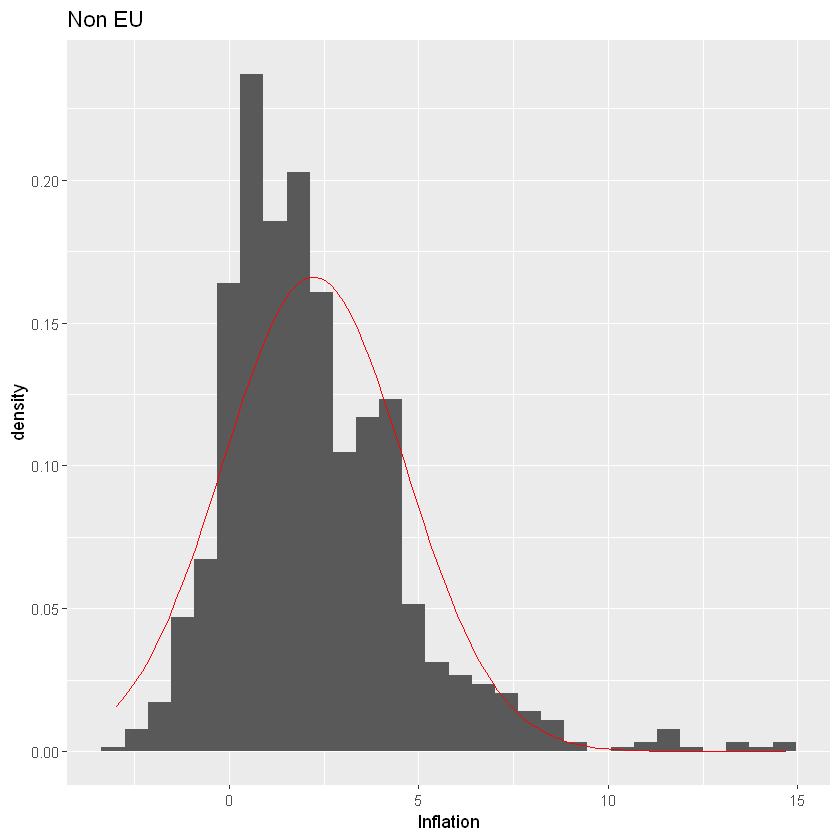

In [4]:
dt_eu <- dt %>% select(-EU..changing.composition.) %>% pivot_longer(cols=-1) %>% mutate(Dates = as.factor(as.yearmon(Dates))) %>% merge(y=country_currency_tibble[country_currency_tibble$Currency == "Euro",], by.x='name', by.y='Country')
dt_noneu <- dt %>% select(-EU..changing.composition.) %>% pivot_longer(cols=-1) %>% mutate(Dates = as.factor(as.yearmon(Dates))) %>% merge(y=country_currency_tibble[country_currency_tibble$Currency == "non-Euro",], by.x='name', by.y='Country')

ggplot(dt_eu, aes(x=value)) +  geom_histogram(aes(y=..density..)) + stat_function(fun = function(x) dnorm(x, mean=mean(dt_eu$value, na.rm=T), sd=sd(dt_eu$value, na.rm=T)), col = "red") + labs(title="EU", x="Inflation")
ggplot(dt_noneu, aes(x=value)) +  geom_histogram(aes(y=..density..)) + stat_function(fun = function(x) dnorm(x, mean=mean(dt_noneu$value, na.rm=T), sd=sd(dt_noneu$value, na.rm=T)), col = "red") + labs(title="Non EU", x="Inflation")

shapiro.test(dt_eu$value)
shapiro.test(dt_noneu$value)

wilcox.test(dt_eu$value, dt_noneu$value, alternative = "less")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


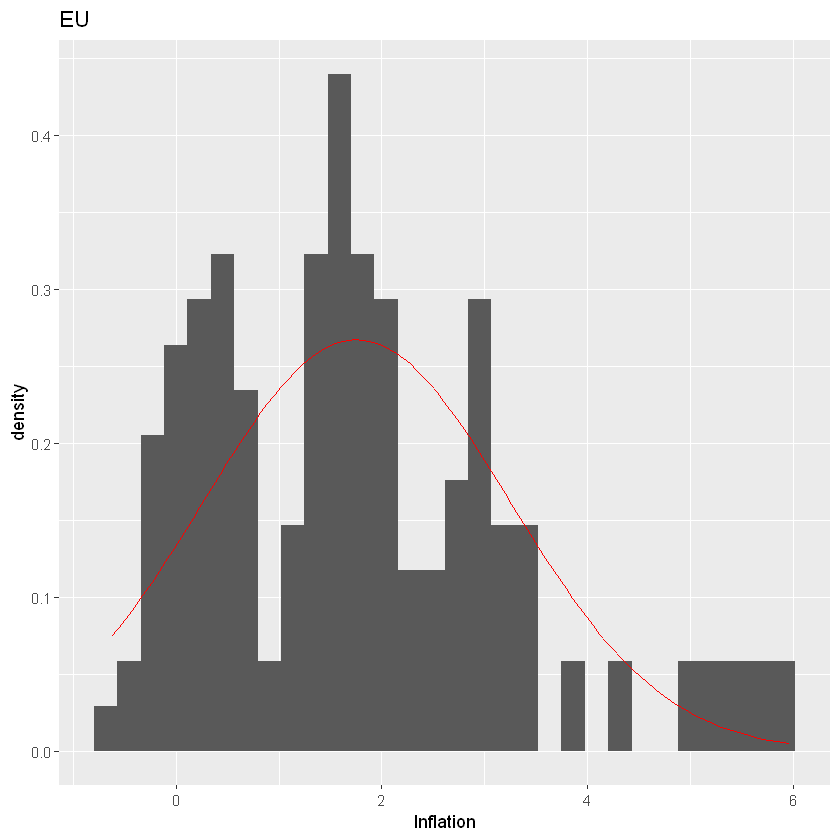


	Shapiro-Wilk normality test

data:  dt_eu$value
W = 0.93519, p-value = 2.321e-06



	Shapiro-Wilk normality test

data:  dt_noneu$value
W = 0.95204, p-value = 4.853e-05



	Wilcoxon signed rank test with continuity correction

data:  dt_eu$value and dt_noneu$value
V = 2656.5, p-value = 8.55e-09
alternative hypothesis: true location shift is less than 0


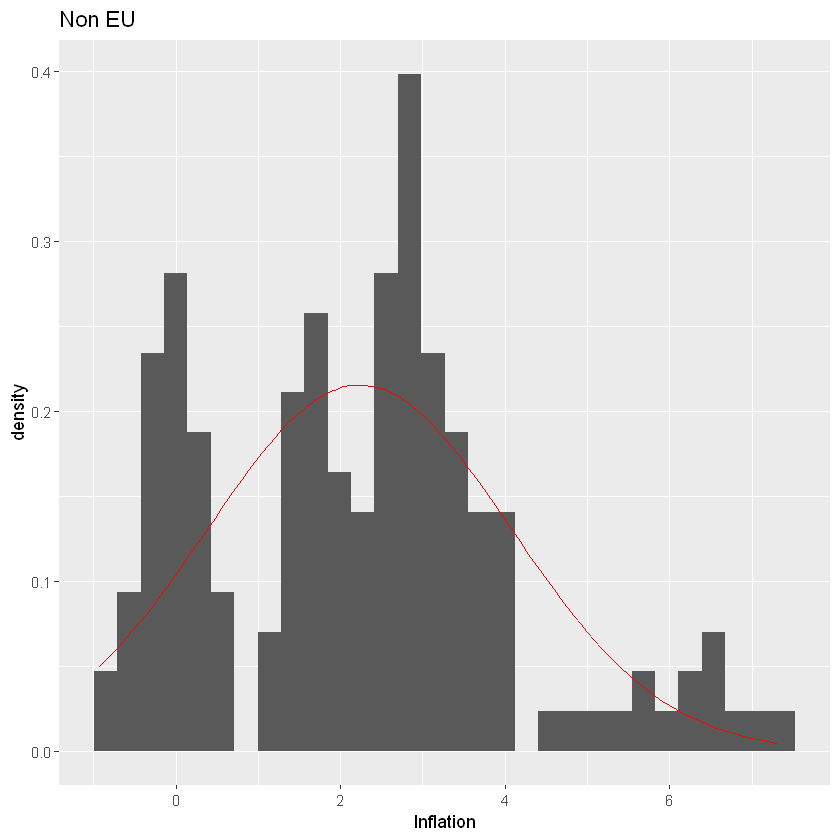

In [5]:
dt_noneu %>% group_by(Dates) %>% summarise(value=mean(value)) -> dt_noneu
dt_eu %>% group_by(Dates) %>% summarise(value=mean(value)) -> dt_eu

ggplot(dt_eu, aes(x=value)) +  geom_histogram(aes(y=..density..)) + stat_function(fun = function(x) dnorm(x, mean=mean(dt_eu$value, na.rm=T), sd=sd(dt_eu$value, na.rm=T)), col = "red") + labs(title="EU", x="Inflation")
ggplot(dt_noneu, aes(x=value)) +  geom_histogram(aes(y=..density..)) + stat_function(fun = function(x) dnorm(x, mean=mean(dt_noneu$value, na.rm=T), sd=sd(dt_noneu$value, na.rm=T)), col = "red") + labs(title="Non EU", x="Inflation")

shapiro.test(dt_eu$value)
shapiro.test(dt_noneu$value)

wilcox.test(dt_eu$value, dt_noneu$value, alternative = "less", paired = T)

## Problem no.2

In [6]:
coin_toss <- function(num_tosses, num_seed, p){
    if (num_seed != -1){
        set.seed(num_seed)
    }
    data <- sample(c(0,1), size = 18, replace = TRUE, prob=c(p, 1-p))
    return (data)
}

In [7]:
data <- coin_toss(18, 40, 0.5)
data

[1] 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0

In [8]:
get_estimators <- function(N, num_tosses, p){
    all_estimators <- list()
    for (i in 1:N){
        data <- coin_toss(num_tosses, -1, p)
        estimator <- as.numeric(mean(data))
        all_estimators <- append(all_estimators, estimator)
    }
    all_estimators <- sort(unlist(all_estimators))
    return (all_estimators)
}
confidence_interval <- function(all_estimators, gamma){
    center <- 814
    side_interval <-length(all_estimators) * gamma / 2
    start_index <- as.integer(clamp((center - side_interval), 1, 1000))
    end_index <- as.integer(clamp((center + side_interval), 1, 1000))
    
    all_estimators <- all_estimators[start_index:end_index]
    confidence_interval_start <- all_estimators[1]
    confidence_interval_end <- tail(all_estimators, n=1)
    interval <- c(confidence_interval_start, confidence_interval_end)
    return (interval)
}

In [9]:
estimators <- get_estimators(1000, 18, 0.5555556)

test_gamma <- function(gamma){
    interval <- confidence_interval(estimators, gamma)
    info <- "confidence_interval = ["
    info <- paste(info, round(interval[1], 2), ",", round(interval[2], 2), "]")
    print(info)
}

#### Test parametru `gamma` = 0.1 

In [10]:
test_gamma(0.1)

[1] "confidence_interval = [ 0.56 , 0.61 ]"


#### Test parametru `gamma` = 0.3

In [11]:
test_gamma(0.3)

[1] "confidence_interval = [ 0.5 , 0.67 ]"


#### Test parametru `gamma` = 0.5

In [12]:
test_gamma(0.5)

[1] "confidence_interval = [ 0.44 , 0.83 ]"


#### Test parametru `gamma` = 0.7

In [13]:
test_gamma(0.7)

[1] "confidence_interval = [ 0.44 , 0.83 ]"


#### Test parametru `gamma` = 0.95

In [14]:
test_gamma(0.95)

[1] "confidence_interval = [ 0.39 , 0.83 ]"


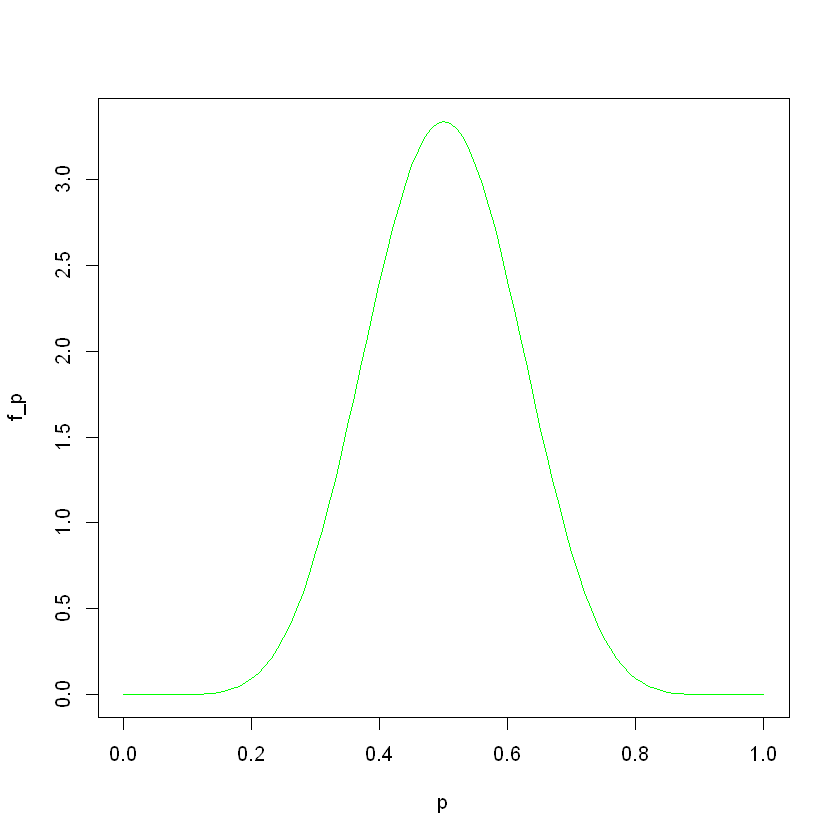

In [15]:
p = seq(0, 1, 0.01)
f_p = dbeta(p, 9, 9)
plot(p, f_p, type = "l", col = "green")

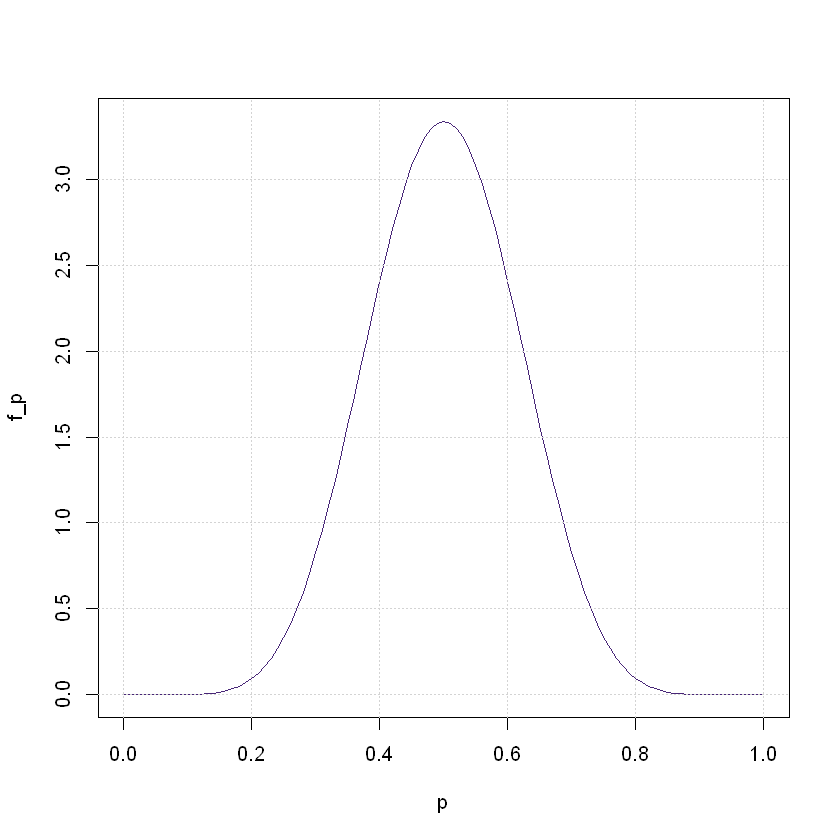

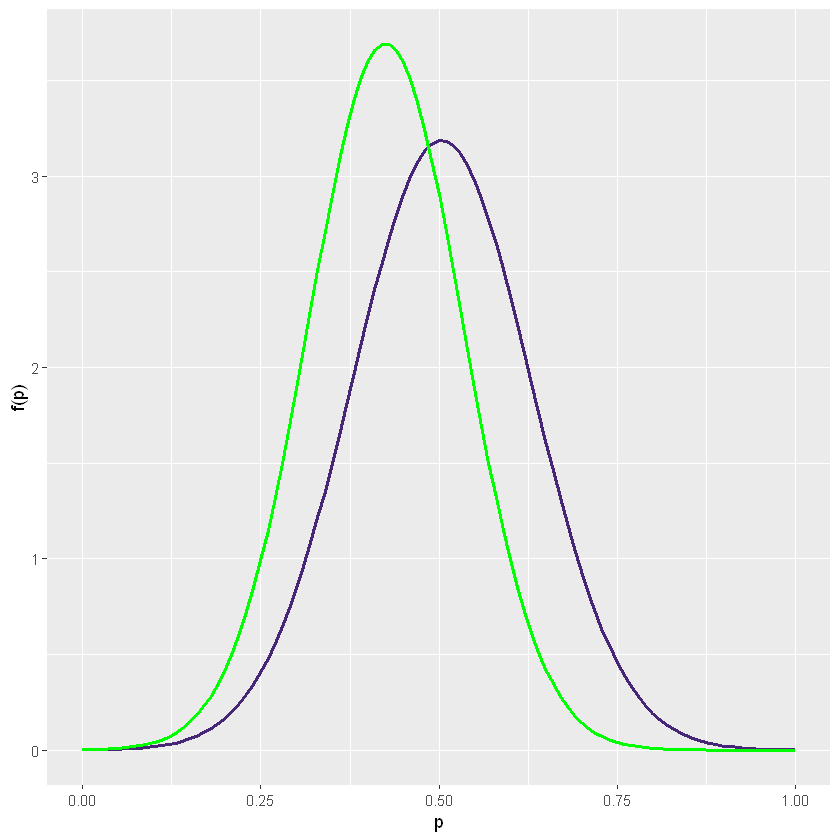

In [16]:
#a priori
alfa = 9
beta = 9

#a posteriori
heads = 4
tails = 8

p = seq(0, 1, 0.01)
f_p = dbeta(p, alfa, beta)
plot(p, f_p, type = "l", col = "#482677")

y2 = rbeta(alfa+beta, alfa, beta)
y3 = rbeta(alfa+beta, alfa + heads, beta + tails)

y2_df <- as.data.frame(y2)
y3_df <- as.data.frame(y3)

ggplot(y2_df, aes(y = y2)) +
  stat_function(fun = dnorm, args = list(mean = mean(y2), sd = sd(y2)), color="#482677", linewidth=1)  +
  stat_function(fun = dnorm, args = list(mean = mean(y3), sd = sd(y3)), color="#00FF00", linewidth=1) +
  xlab("p") +
  ylab("f(p)") +
  grid()